In [1]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G

from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
from shapey import Box
import popsims
from scipy import stats
import astropy.units as u
from scipy.signal import find_peaks

path_plot = '/users/caganze/research/stellarstreams/figures/stream/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


In [2]:
#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#potential and hamiltonian
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)

galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

NSAMPLES_STREAM={27.15: 260, 28.54:1300}

gap_center=(55, 20)

In [3]:
def recenter(x, y, c):
    xshift=np.nanmedian(x-c[0])
    yshift= np.nanmedian(y-c[1])
    return x-xshift, y-yshift
                    
    
def get_background(center, distrange='50_60', dist_mod=23.49, FeH_phot=-1., mag_limit=27.15):
    
    #compute projected field of view
    d_M31 = ((10**((dist_mod/5)+1)))/1000
    kpc_conversion = np.pi * d_M31 / 180.
    print ('distance {} , kpc conversion {}'.format(d_M31, kpc_conversion))
    
    scaled_fov= 0.52*u.degree*( kpc_conversion*u.kpc/u.degree)
    scaled_arcmin= (10*u.arcmin.to(u.degree)*u.degree)*( kpc_conversion*u.kpc/u.degree)
    
    outfile = isochrone_path+'/WFIfilters_extendedIsochrones_allbands_dmod{:.2f}_maglimit{}_M31_{}kpc.txt'.format(dist_mod, mag_limit, distrange)
    
    bckgd=ascii.read(outfile).to_pandas()
    bckgd=(bckgd[np.logical_and(bckgd.Z < mag_limit, bckgd.FeH_phot<FeH_phot)]).reset_index(drop=True)
    
    x=kpc_conversion*bckgd.RA.values
    y=kpc_conversion*bckgd.DEC.values
    
    xr, yr=recenter(x, y, center)
    
    bx=roman_fov(center, scaled_fov.value, scaled_fov.value)
    bx.color='none'
    bx.edgecolor='r'
    df=pd.DataFrame()
    bckgd['x_coord']=xr
    bckgd['y_coord']=yr
    
    print (bx.xrange, bx.yrange)
    return {'box': bx, 'data': bckgd.iloc[bx.select(bckgd[['x_coord', 'y_coord']]).index], \
            'center': center, 'all':  bckgd}

        
def transform_to_phi_coordinates(st, end_points=None):
    stream_p=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.z.unit,
                          vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    #transform to stream coordinate frame 
    stream_c = stream_p.to_coord_frame(astro_coord.ICRS)
    
    if end_points is  None:
        min_ra_id= np.argmin(stream_c.ra.degree)
        max_ra_id=np.argmax(stream_c.ra.degree)
        
        end_points=astro_coord.SkyCoord(ra=[stream_c.ra.degree[min_ra_id], \
                                           stream_c.ra.degree[max_ra_id]]*u.deg,
                            dec=[stream_c.dec.degree[min_ra_id], \
                                           stream_c.dec.degree[max_ra_id]]*u.deg)

    fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
    return {'icrs': stream_c, 'great_circ': stream_c.transform_to(fr)}

def roman_fov(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    #b._data=[ra,## dec]
    return b

#length and ith of the stream 
#procedure 
def compute_width(m, vc, Rgc):
    return Rgc*((m*G/(vc**2*Rgc))**(1/3))

def compute_physical_length(Rgc, m, vc, t):
    return  ((m*vc/Rgc)**(1/3))*t

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def count_stars(x, y, kernel_density=False, direction='r', bins=32, mask=None, bw_method=None):
    #compute density along the stream
    if mask=='None':
        mask=np.ones_like(x).astype(bool)
        
    rvals=(x**2+y**2)**0.5
    
    if direction=='x':
        rvals=x
        
    if direction=='y':
        rvals=y
     
    counts0, binedges= np.histogram(rvals, bins=bins, density=True)
    counts0=np.append(counts0,counts0[-1])
    assert len(binedges)== len(counts0)
    counts= np.interp(rvals, binedges ,counts0)
    assert len(counts)==len(rvals)
    
    if  bw_method is None:
        bw_method=np.nanstd(rvals)/1.1
        
    if kernel_density:
        kernel= stats.gaussian_kde(rvals, bw_method= bw_method)
        counts = kernel.pdf(rvals)
    return counts, rvals.flatten()

def evolve_stream_in_time(st, time, dt=1*u.Myr, progenitor=False):
    time_dict={'t1': 0*u.Myr, 't2': time, 'dt': dt}
    #make a phase space position objec
    stpos=None
    if progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x.value, st.y.value, st.z.value])*st.x.unit,
                              vel=np.array([st.v_x.value, st.v_y.value, st.v_z.value])*st.v_z.unit)
    if not progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.x.unit,
                              vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(stpos,  **time_dict)
    
    #integrate in time
    new_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                       z= final_stream_orbit.z[-1], v_x=final_stream_orbit.v_x[-1],\
                       v_y=final_stream_orbit.v_y[-1], v_z=final_stream_orbit.v_z[-1],\
                       frame=galcen_frame)
    return new_stream_coord

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)


def make_density_plot(values, ax, cmap=plt.cm.coolwarm, bins=100, hist=False):
    if not hist:
        kernel = stats.gaussian_kde(values)
        x, y=np.meshgrid(np.linspace(values[0].min()-0.9, values[0].max(), bins), \
                         np.linspace(values[1].min()-0.9, values[1].max(), bins))
        positions = np.vstack([x.ravel(), y.ravel()])
        Z = np.reshape(kernel(positions).T, x.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax.scatter(positions[0], positions[1], c=kernel(positions), cmap=cmap)
    if hist:
        _= ax.hist2d(values[0], values[1], cmap=cmap, bins=bins)

In [4]:
bck=get_background((57.5, 55), distrange='50_60', dist_mod=23.49, FeH_phot=-1., mag_limit=28.54)

distance 498.88448746001166 , kpc conversion 8.707176893301567
[55.23613400774159, 59.76386599225841] [52.73613400774159, 57.26386599225841]


In [48]:
vhalo=50
mstream=1
mhalo='5.00e+06'

In [49]:
filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc50*_mhalo{}*vhalo{}_*.npy'.format(mstream,mhalo, vhalo)))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
evolved_st= evolve_stream_in_time(st, .5*u.Gyr)
choices=np.random.choice(range(0, len(evolved_st)), 1300)

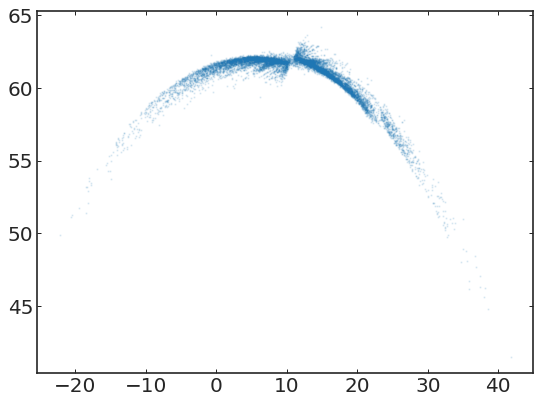

In [50]:
fig, ax=plt.subplots()
ax.scatter(evolved_st.x, evolved_st.y, s=1, alpha=0.1)

In [16]:
data = pd.DataFrame()
b=bck['box']

In [17]:
b.xrange, b.yrange

([55.23613400774159, 59.76386599225841],
 [52.73613400774159, 57.26386599225841])

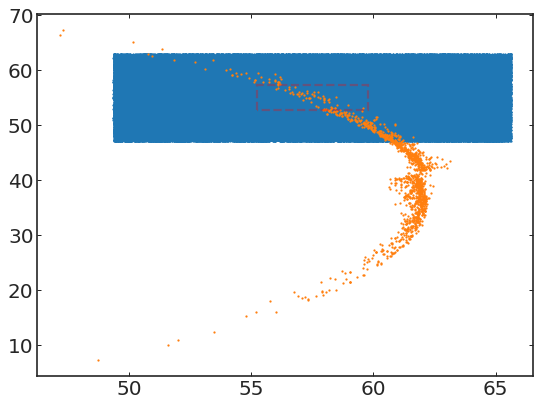

In [25]:
fig, ax=plt.subplots()
ax.scatter(bck['all'].x_coord, bck['all'].y_coord, s=1)
ax.scatter(evolved_st.y.value[choices], evolved_st.z.value[choices]+31, s=1)


data['x']=np.concatenate([bck['all'].x_coord, evolved_st.y.value[choices]])
data['y']=np.concatenate([bck['all'].y_coord, evolved_st.z.value[choices]+31])

selected=b.select((data))
b.plot(ax=ax)


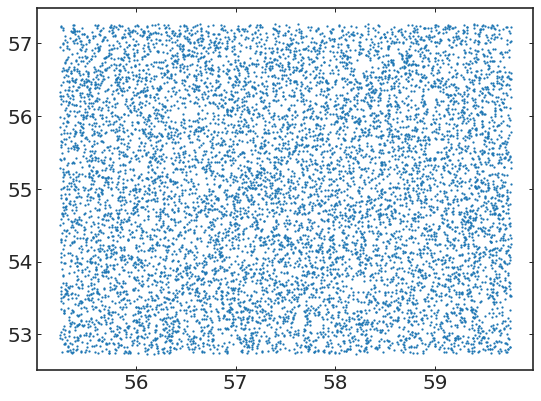

In [51]:
fig, ax=plt.subplots()
ax.scatter(selected.x, selected.y, s=1)


In [63]:
def KL_divergence_poisson(lambda0, lambda1):
    return lambda0-lambda1+ lambda1*np.log(lambda1/lambda0)